In [1]:
# Ignore Warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Import required libraries
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [2]:
#Read the CSV file.
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
#Prepare train and test DF
y_train = train['label']
X_train = train.drop(['label'], axis = 1)
X_test = test.copy()
#Delete to free up space 
del train
del test
random_seed = 2
#splitting training data into train and validation data in 9:1 ratio
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = random_seed)

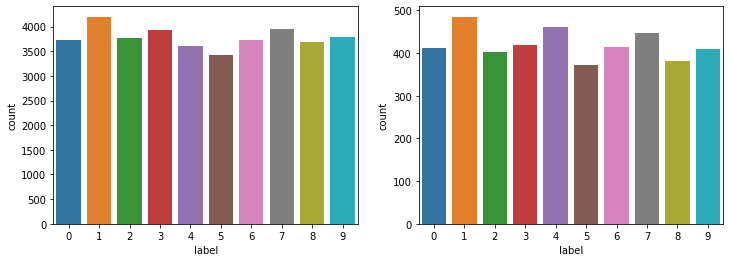

In [4]:
#No of examples according to laebl
fig, axs = plt.subplots(nrows = 1, ncols=2,figsize = (12,4))
sns.countplot(y_train, ax= axs[0])
sns.countplot(y_val,  ax = axs[1])

In [5]:
#one hot encoding on train and validation data
pd.set_option('display.max_columns',800)
y_train = to_categorical(y_train, num_classes = 10)
y_val =  to_categorical(y_val, num_classes = 10)

In [6]:
y_val.shape

(4200, 10)

In [7]:
#Normalize the train, test, validation data
X_train = X_train/255.0
X_test = X_test/255.0
X_val = X_val/255.0

#Reshape data into 28*28*1 dimention(grey scale image)
X_train = X_train.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)
X_val = X_val.values.reshape(-1, 28, 28, 1)

In [8]:
#display train set exampples
def display_img():
    fig,axs = plt.subplots(nrows = 2, ncols = 5, figsize=(10,4))
    axs = axs.ravel()
    for i in range(0,10):
        random_select = np.random.randint(0, X_train.shape[0])
        axs[i].imshow(X_train[random_select][:,:,0])
        axs[i].axis('off')

    plt.subplots_adjust(hspace = 0.3, wspace = 0.7)

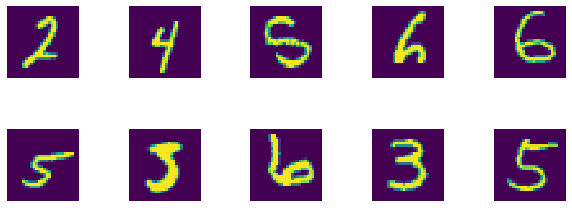

In [9]:
display_img()

In [37]:
#Define CNN Model

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop, Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

def define_model():
        model = Sequential()
        model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                         activation ='relu', input_shape = (28,28,1)))
        #Remove comment for better acuracy and run the model. But it cost double the computation time for me
        '''model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                        activation ='relu'))'''
        model.add(BatchNormalization())
        model.add(MaxPool2D(pool_size=(2,2)))
        model.add(Dropout(0.2))


        model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                         activation ='relu'))
        #Remove comment for better accuracy and run the model. But it cost double the computation time for me
        '''model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                         activation ='relu'))'''
        model.add(BatchNormalization())
        model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
        model.add(Dropout(0.2))
        
        model.add(Flatten())
        model.add(Dense(512, activation = "relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))
        model.add(Dense(10, activation = "softmax"))
        model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
        return model

In [38]:
#data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [39]:
# Fit the model
Batch_size = 85
learning_rate_check = ReduceLROnPlateau(monitor = 'val_accuracy', patience=2, verbose = 1, factor= 0.5, min_lr = 0.00001)
model = define_model()
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=Batch_size),
                              epochs = 20, validation_data = (X_val,y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // Batch_size
                              , callbacks=[learning_rate_check])
score = model.evaluate(X_val, y_val, verbose=1)

Epoch 1/20
 - 224s - loss: 0.2889 - accuracy: 0.9109 - val_loss: 1.3152 - val_accuracy: 0.5943
Epoch 2/20
 - 244s - loss: 0.1116 - accuracy: 0.9651 - val_loss: 0.0604 - val_accuracy: 0.9819
Epoch 3/20
 - 242s - loss: 0.0862 - accuracy: 0.9722 - val_loss: 0.0373 - val_accuracy: 0.9879
Epoch 4/20
 - 239s - loss: 0.0756 - accuracy: 0.9765 - val_loss: 0.0415 - val_accuracy: 0.9869
Epoch 5/20
 - 225s - loss: 0.0654 - accuracy: 0.9792 - val_loss: 0.0275 - val_accuracy: 0.9900
Epoch 6/20
 - 243s - loss: 0.0628 - accuracy: 0.9801 - val_loss: 0.0331 - val_accuracy: 0.9895
Epoch 7/20
 - 241s - loss: 0.0578 - accuracy: 0.9820 - val_loss: 0.0319 - val_accuracy: 0.9905
Epoch 8/20
 - 228s - loss: 0.0567 - accuracy: 0.9816 - val_loss: 0.0329 - val_accuracy: 0.9893
Epoch 9/20
 - 241s - loss: 0.0510 - accuracy: 0.9833 - val_loss: 0.0269 - val_accuracy: 0.9910
Epoch 10/20
 - 242s - loss: 0.0522 - accuracy: 0.9842 - val_loss: 0.0323 - val_accuracy: 0.9914
Epoch 11/20
 - 220s - loss: 0.0464 - accuracy: 0.

In [40]:
print("Test loss: {}  \nTest Accuracy: {}".format(score[0], score[1]))

Test loss: 0.019332540912160072  
Test Accuracy: 0.9950000047683716


In [48]:
history.history

{'val_loss': [1.3151697340465727,
  0.060426625519591784,
  0.037346525003002694,
  0.04151109888861399,
  0.027523469232117004,
  0.03307370429836391,
  0.03185930872887617,
  0.03293606314705574,
  0.026869430052569702,
  0.032283109740750486,
  0.028587202038588225,
  0.026956328286074235,
  0.0278208787705461,
  0.028594633050705028,
  0.02318579954799567,
  0.021641632812679744,
  0.01837946774515634,
  0.021993004402091693,
  0.02185060244857942,
  0.01933254032148744],
 'val_accuracy': [0.5942857265472412,
  0.9819047451019287,
  0.9878571629524231,
  0.9869047403335571,
  0.9900000095367432,
  0.9895238280296326,
  0.9904761910438538,
  0.9892857074737549,
  0.9909523725509644,
  0.991428554058075,
  0.9916666746139526,
  0.9926190376281738,
  0.991428554058075,
  0.991190493106842,
  0.9923809766769409,
  0.993571400642395,
  0.994523823261261,
  0.9923809766769409,
  0.9930952191352844,
  0.9950000047683716],
 'loss': [0.28889351835750693,
  0.11159617444504032,
  0.086238888

In [49]:
def summarize_diagnostics(history):
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    # save plot to file
    #filename = sys.argv[0].split('/')[-1]
    #plt.savefig(filename + '_plot.png')
    #plt.close()
    plt.subplots_adjust(hspace = 0.5, wspace = 0.9)

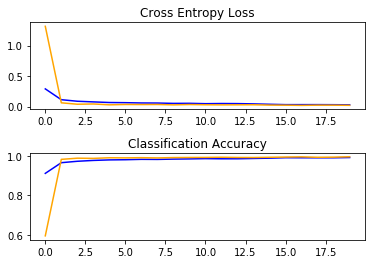

In [50]:
summarize_diagnostics(history)

In [41]:
#Predict the output on test data
y_pred = model.predict(X_test)

In [29]:
#prediction score
y_pred.shape

(28000, 10)

In [42]:
#get the index value with higest probability
y_pred_classes = np.argmax(y_pred,axis = 1) 

In [31]:
y_pred_classes.shape

(28000,)

In [43]:
#create submission file
results = pd.Series(y_pred_classes,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen7.csv",index=False)

In [46]:
#Display images with predicted output.
def display_img():
    fig,axs = plt.subplots(nrows = 2, ncols = 5, figsize=(10,4))
    axs = axs.ravel()
    for i in range(0,10):
        random_select = np.random.randint(0, X_test.shape[0])
        axs[i].imshow(X_test[random_select][:,:,0])
        axs[i].set_title('predicted label: {}'.format(y_pred_classes[random_select]))
        axs[i].axis('off')

    plt.subplots_adjust(hspace = 0.3, wspace = 0.7)

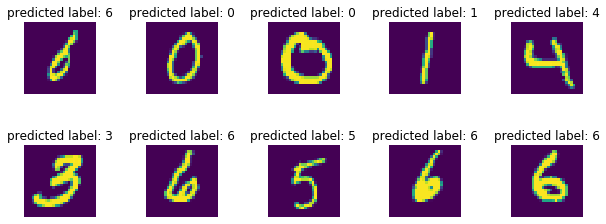

In [47]:
display_img()